In [1]:
import pandas as pd
import numpy as np
import dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Load Dataset

In [3]:
df = pd.read_parquet('dataset.parquet')

In [4]:
df

,time,sample,anomaly,category,setting,action,active,robot_voltage,robot_current,io_current,...,torque_sensor_a_6,torque_sensor_b_6,motor_iq_6,motor_id_6,power_motor_el_6,power_motor_mech_6,power_load_mech_6,motor_voltage_6,supply_voltage_6,brake_voltage_6
0,0.000000,0,True,0,0,0,0,48.582687,0.322263,0.087890,...,0.069086,-0.066240,0.161936,-0.019600,0.115915,0.0,1.157006e-05,0.729223,47.783798,11.177029
1,0.010047,0,True,0,0,0,0,48.582687,0.527340,0.087890,...,0.055269,-0.063480,0.142992,0.020944,0.134123,0.0,-7.832955e-07,0.630203,47.783798,10.976003
2,0.020135,0,True,0,0,0,0,48.561890,0.380857,0.087890,...,0.060796,-0.080041,0.145380,0.011475,0.115405,0.0,4.344085e-07,0.620702,47.803898,11.217231
3,0.030203,0,True,0,0,0,0,48.582687,0.483395,0.087890,...,0.046979,-0.066240,0.147767,0.002005,0.097916,0.0,2.882664e-06,0.623614,47.783798,11.177029
4,0.040257,0,True,0,0,0,0,48.582687,0.307615,0.087890,...,0.046979,-0.074521,0.147767,0.002005,0.104346,0.0,6.304338e-07,0.499930,47.803898,11.156923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321685,10.716863,2121,False,12,76,13,1,48.561890,0.688472,0.087890,...,0.055269,-0.063480,0.133460,0.024379,0.103935,0.0,-1.502957e-05,0.595642,47.803898,11.217231
2321686,10.726921,2121,False,12,76,13,1,48.561890,0.644527,0.073242,...,0.041452,-0.044160,0.142870,0.021766,0.078053,0.0,7.213437e-07,0.517480,47.803898,10.976000
2321687,10.737022,2121,False,12,76,13,1,48.541092,0.908197,0.087890,...,0.066323,-0.049680,0.124408,-0.008216,0.080420,0.0,9.829410e-06,0.496470,47.783798,11.197131
2321688,10.747115,2121,False,12,76,13,1,48.582687,0.688472,0.117187,...,0.069086,-0.044160,0.124408,-0.008216,0.092157,0.0,7.721170e-06,0.817346,47.783798,11.116721


In [5]:
# Excluding ['time','sample','category','setting','action','active']
df = df.drop(['time','sample','category','setting','action','active'], axis=1)

# Converting the column 'anomaly' from boolean to int
df['anomaly'] = df['anomaly'].astype(int)

In [6]:
df

,anomaly,robot_voltage,robot_current,io_current,system_current,target_position_1,target_velocity_1,target_acceleration_1,target_torque_1,computed_inertia_1,...,torque_sensor_a_6,torque_sensor_b_6,motor_iq_6,motor_id_6,power_motor_el_6,power_motor_mech_6,power_load_mech_6,motor_voltage_6,supply_voltage_6,brake_voltage_6
0,1,48.582687,0.322263,0.087890,0.278318,-0.341433,-0.0,-0.0,0.127406,2.251855,...,0.069086,-0.066240,0.161936,-0.019600,0.115915,0.0,1.157006e-05,0.729223,47.783798,11.177029
1,1,48.582687,0.527340,0.087890,0.410153,-0.341433,-0.0,-0.0,0.314227,2.251855,...,0.055269,-0.063480,0.142992,0.020944,0.134123,0.0,-7.832955e-07,0.630203,47.783798,10.976003
2,1,48.561890,0.380857,0.087890,0.292967,-0.341433,-0.0,-0.0,0.002657,2.251855,...,0.060796,-0.080041,0.145380,0.011475,0.115405,0.0,4.344085e-07,0.620702,47.803898,11.217231
3,1,48.582687,0.483395,0.087890,0.263670,-0.341433,-0.0,-0.0,-0.128248,2.251855,...,0.046979,-0.066240,0.147767,0.002005,0.097916,0.0,2.882664e-06,0.623614,47.783798,11.177029
4,1,48.582687,0.307615,0.087890,0.263670,-0.341433,-0.0,-0.0,0.097738,2.251855,...,0.046979,-0.074521,0.147767,0.002005,0.104346,0.0,6.304338e-07,0.499930,47.803898,11.156923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321685,0,48.561890,0.688472,0.087890,0.263670,-0.341433,-0.0,-0.0,-1.652499,2.251218,...,0.055269,-0.063480,0.133460,0.024379,0.103935,0.0,-1.502957e-05,0.595642,47.803898,11.217231
2321686,0,48.561890,0.644527,0.073242,0.219725,-0.341433,-0.0,-0.0,-1.703043,2.251505,...,0.041452,-0.044160,0.142870,0.021766,0.078053,0.0,7.213437e-07,0.517480,47.803898,10.976000
2321687,0,48.541092,0.908197,0.087890,0.263670,-0.341433,-0.0,-0.0,-1.405120,2.251686,...,0.066323,-0.049680,0.124408,-0.008216,0.080420,0.0,9.829410e-06,0.496470,47.783798,11.197131
2321688,0,48.582687,0.688472,0.117187,0.278318,-0.341433,-0.0,-0.0,-1.668486,2.251787,...,0.069086,-0.044160,0.124408,-0.008216,0.092157,0.0,7.721170e-06,0.817346,47.783798,11.116721


# Isolation Forest

I would like to try two approaches:

## First

In [7]:
#check statistically important features
columns= df.drop('anomaly', axis=1).columns
normal= df[df.anomaly==0]
anomal= df[df.anomaly==1]
sample_size=len(anomal)
significant_features=[]
critical_value=2.58
def ztest(feature):
    
    mean = normal[feature].mean()
    std = anomal[feature].std()
    zScore = (anomal[feature].mean() - mean) / (std/np.sqrt(sample_size))
    
    return zScore

for i in columns:
    
    z_vavlue=ztest(i)
    
    if( abs(z_vavlue) >= critical_value):    
        print(i," is statistically significant") #Reject Null hypothesis. i.e. H0
        significant_features.append(i)

robot_voltage  is statistically significant
robot_current  is statistically significant
io_current  is statistically significant
system_current  is statistically significant
target_position_1  is statistically significant
computed_inertia_1  is statistically significant
motor_position_1  is statistically significant
joint_position_1  is statistically significant
motor_torque_1  is statistically significant
torque_sensor_a_1  is statistically significant
torque_sensor_b_1  is statistically significant
motor_iq_1  is statistically significant
motor_id_1  is statistically significant
power_motor_el_1  is statistically significant
power_motor_mech_1  is statistically significant
power_load_mech_1  is statistically significant
supply_voltage_1  is statistically significant
brake_voltage_1  is statistically significant
target_position_2  is statistically significant
computed_inertia_2  is statistically significant
computed_torque_2  is statistically significant
motor_position_2  is statistic

/var/folders/4n/mn6h9015417130zyvxc9bs200000gn/T/ipykernel_29427/3218368832.py:12: RuntimeWarning: invalid value encountered in scalar divide
  zScore = (anomal[feature].mean() - mean) / (std/np.sqrt(sample_size))


computed_torque_6  is statistically significant
motor_position_6  is statistically significant
joint_position_6  is statistically significant
torque_sensor_a_6  is statistically significant
torque_sensor_b_6  is statistically significant
motor_iq_6  is statistically significant
motor_id_6  is statistically significant
power_motor_el_6  is statistically significant
power_motor_mech_6  is statistically significant
power_load_mech_6  is statistically significant
supply_voltage_6  is statistically significant
brake_voltage_6  is statistically significant


In [8]:
#delete non significant features
significant_features.append('anomaly')
df= df[significant_features]

inliers = df[df.anomaly==0]
ins = inliers.drop(['anomaly'], axis=1)

outliers = df[df.anomaly==1]
outs = outliers.drop(['anomaly'], axis=1)

ins.shape, outs.shape

((1488328, 82), (833362, 82))

In [9]:
df.shape

(2321690, 83)

In [10]:
def normal_accuracy(values):
    
    tp=list(values).count(1)
    total=values.shape[0]
    accuracy=np.round(tp/total,4)
    
    return accuracy

def anomaly_accuracy(values):
    
    tn=list(values).count(-1)
    total=values.shape[0]
    accuracy=np.round(tn/total,4)
    
    return accuracy

In [11]:
state= 42

ISF = IsolationForest(random_state=state)
ISF.fit(ins) #ins = observation with anomaly==0 (i.e. normal values)

normal_isf = ISF.predict(ins)
anomaly_isf = ISF.predict(outs)

in_accuracy_isf = normal_accuracy(normal_isf)
out_accuracy_isf = anomaly_accuracy(anomaly_isf)
print("Accuracy in Detecting Normal Cases:", in_accuracy_isf)
print("Accuracy in Detecting Fraud Cases:", out_accuracy_isf)

Accuracy in Detecting Normal Cases: 0.8109
Accuracy in Detecting Fraud Cases: 0.1966


don't run 

In [ ]:
# Definisci la distribuzione degli iperparametri
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_samples': [0.5, 0.7, 1.0],
    'contamination': ['auto', 0.1, 0.2]
}

# Crea un oggetto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=IsolationForest(random_state=state),
                                   param_distributions=param_dist,
                                   n_iter=2,
                                   scoring='accuracy',
                                   cv=5,
                                   random_state=state)

# Esegui la ricerca casuale utilizzando solo i dati normali
random_search.fit(ins)

# Ottieni i migliori iperparametri trovati
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

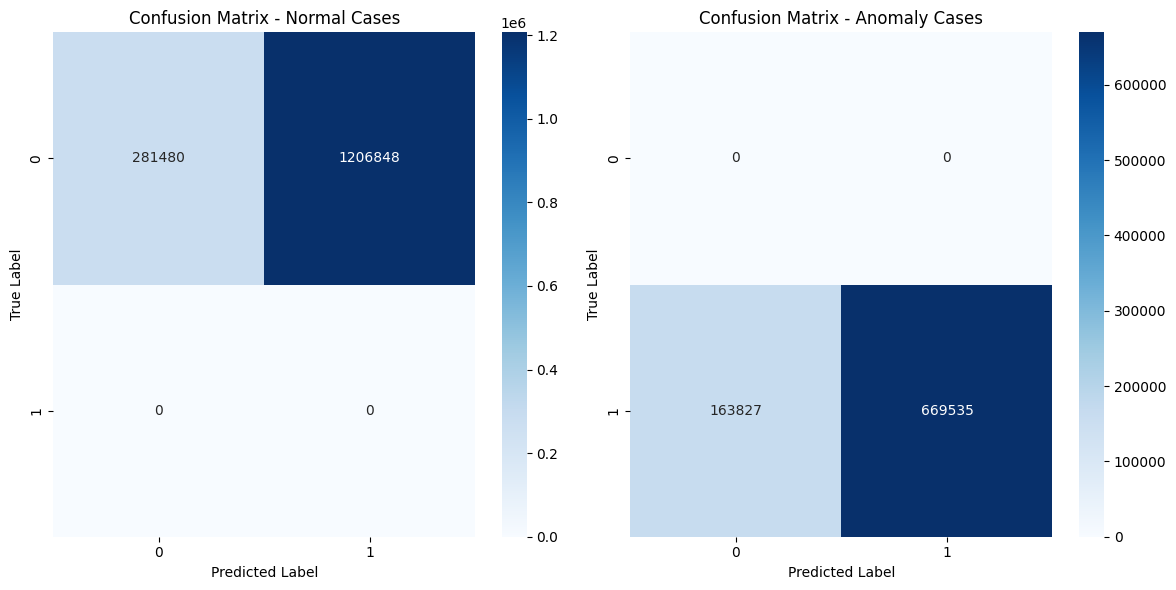

In [12]:

normal_predictions = ISF.predict(ins)
anomaly_predictions = ISF.predict(outs)

conf_matrix_normal = confusion_matrix([-1] * len(ins), normal_predictions) 
conf_matrix_anomaly = confusion_matrix([1] * len(outs), anomaly_predictions) 

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_normal, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Normal Cases')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_anomaly, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Anomaly Cases')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()


## Second

In [13]:
#reload the dataset
df = pd.read_parquet('dataset.parquet')

In [14]:
X = df.drop('anomaly', axis=1)
y = df['anomaly']

In [15]:
model = IsolationForest(contamination='auto', random_state=42)
model.fit(X)
anomaly_predictions = model.predict(X)
anomaly_predictions_mapped = [1 if pred == -1 else 0 for pred in anomaly_predictions]
from sklearn.metrics import classification_report

print(classification_report(y, anomaly_predictions_mapped))

              precision    recall  f1-score   support

       False       0.64      0.82      0.72   1488328
        True       0.38      0.19      0.25    833362

    accuracy                           0.60   2321690
   macro avg       0.51      0.51      0.49   2321690
weighted avg       0.55      0.60      0.55   2321690



# K-Means

In [16]:
#reload dataset
df = pd.read_parquet('dataset.parquet')

In [17]:
X = df.drop('anomaly', axis=1)
y = df['anomaly']

In [18]:
n_clusters = 2  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

distances = kmeans.transform(X)

avg_distances = np.mean(distances, axis=1)

threshold = np.percentile(avg_distances, 95)  

anomalies = (avg_distances > threshold).astype(int)

print("Number of anomalies:", np.sum(anomalies))
report_kmeans = classification_report(y, anomalies)

print("Classification Report - K-Means:\n", report_kmeans)

Number of anomalies: 116085
Classification Report - K-Means:
               precision    recall  f1-score   support

       False       0.65      0.96      0.77   1488328
        True       0.49      0.07      0.12    833362

    accuracy                           0.64   2321690
   macro avg       0.57      0.51      0.45   2321690
weighted avg       0.59      0.64      0.54   2321690



Isolation Forest performs better

## Elbow Method

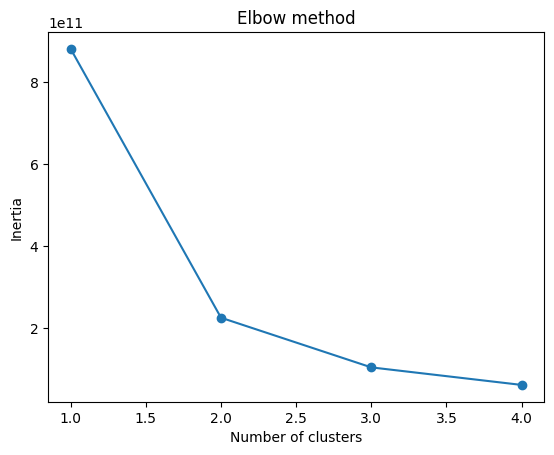

In [19]:
inertias = []

for i in range(1,5):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,5), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

we choose k = 2

## Visualization with PCA dimensionality reduction

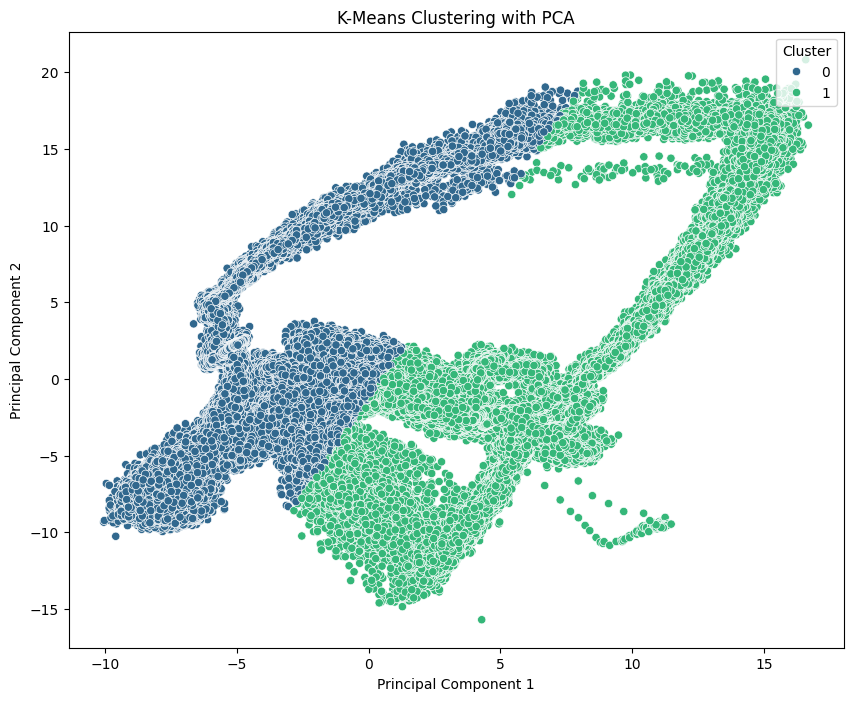

In [21]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_pca)

labels = kmeans.labels_

X_pca_clustered = pd.DataFrame(X_pca, columns=['Componente principale 1', 'Componente principale 2'])
X_pca_clustered['Cluster'] = labels

plt.figure(figsize=(10, 8))
sns.scatterplot(data=X_pca_clustered, x='Componente principale 1', y='Componente principale 2', hue='Cluster', palette='viridis')
plt.title('K-Means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()